In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import itertools

from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.nn import functional as F

from sklearn.metrics import r2_score

from tqdm import tqdm

%matplotlib inline

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
arousal = pd.read_csv("/content/drive/MyDrive/UJ/ML/Project/arousal_cont_average.csv", index_col = 0)
valence = pd.read_csv("/content/drive/MyDrive/UJ/ML/Project/valence_cont_average.csv", index_col = 0)

arousal = arousal.iloc[:,:-1] # We don't take the last timestamp, because some songs are slightly shorter
valence = valence.iloc[:,:-1]

annotations = pd.read_csv("/content/drive/MyDrive/UJ/ML/Project/songs_info_ttv.csv", index_col = 0)

train_ids = annotations.index[annotations["ttv"] == "train"]
valid_ids = annotations.index[annotations["ttv"] == "validation"]
test_ids = annotations.index[annotations["ttv"] == "evaluation"]

print(f"{len(train_ids)} train cases | {len(valid_ids)} validation cases | {len(test_ids)} test cases")

495 train cases | 124 validation cases | 125 test cases


# Functions definition

In [4]:
def load_for_stats(dataset, ids): # We have overlapping fragments, so we need to calculate each part of the song only once
  X_raw = []
  for i in ids:
    df = pd.read_csv(f"/content/drive/MyDrive/UJ/ML/Project/{dataset}/{i}.csv")
    df = df.iloc[:890,:-2] # Normalizing the length + ommiting timestamps and song IDs
    X = df.to_numpy()
    X_raw.append(X)

  X_raw = np.stack(X_raw)
  return torch.tensor(X_raw, dtype = torch.float)


def get_mean_std(dataset):
  return dataset.mean(dim = (0,1)), dataset.std(dim = (0,1))


def load_X(dataset, ids, seq_len, step = 0.05):
  X_raw = []
  for i in ids:
    song_fragments = []
    df = pd.read_csv(f"/content/drive/MyDrive/UJ/ML/Project/{dataset}/{i}.csv")
    df = df.iloc[:,:-2] # Ommiting timestamps and song IDs
    X = df.to_numpy()
    for ending_time in np.arange(15.0, 45.0, 0.5): # We don't want the final annotation, as some songs are slightly shorter
      end_idx = int(ending_time / step) + 1 
      start_idx = end_idx - seq_len
      song_fragments.append(X[start_idx:end_idx])
    X_raw += song_fragments

  X_raw = np.stack(X_raw)
  return torch.tensor(X_raw, dtype = torch.float)


In [5]:
def get_rmse(model, X, a, v):
  a_pred, v_pred = model(X.cuda())
  a_rmse = torch.sqrt(torch.mean((a_pred - a.cuda())**2))
  v_rmse = torch.sqrt(torch.mean((v_pred - v.cuda())**2))
  return a_rmse.item(), v_rmse.item()

def get_r2(model, X, a, v):
  a_pred, v_pred = model(X.cuda())
  a_r2 = r2_score(a.numpy(), a_pred.cpu().detach().numpy())
  v_r2 = r2_score(v.numpy(), v_pred.cpu().detach().numpy())
  return a_r2, v_r2

def print_metrics(model):
  X_s = [train_X, valid_X, test_X]
  a_s = [train_a, valid_a, test_a]
  v_s = [train_v, valid_v, test_v]

  rmse_values = []
  r2_values = []
  for X, a, v in zip(X_s, a_s, v_s):
    rmse = get_rmse(model, X, a, v)
    r2 = get_r2(model, X, a, v)
    rmse_values.append(rmse)
    r2_values.append(r2)
  
  a_rmse = "\t".join([str(r[0]) for r in rmse_values])
  v_rmse = "\t".join([str(r[1]) for r in rmse_values])

  a_r2 = "\t".join([str(r[0]) for r in r2_values])
  v_r2 = "\t".join([str(r[1]) for r in r2_values])
  
  print(a_rmse, a_r2, v_rmse, v_r2, sep = "\t")

In [6]:
def train_model(model, train_loader, epochs, report_training_process = False, lr = 0.001, weight_decay = 0.001):
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

  model = model.cuda()

  for epoch in range(epochs):  
    model.train()
    train_a_loss = 0.0
    train_v_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      x, a, v = data

      x = x.cuda()
      a = a.cuda()
      v = v.cuda()

      optimizer.zero_grad()

      # forward + backward + optimize
      a_out, v_out = model(x)
      a_loss = criterion(a_out, a)
      v_loss = criterion(v_out, v) 
      
      total_loss = a_loss + v_loss
      total_loss.backward()


      optimizer.step()

      # print statistics
      train_a_loss += a_loss.item()
      train_v_loss += v_loss.item()
    
    if report_training_process:
      valid_a_loss = 0.0
      valid_v_loss = 0.0
      with torch.no_grad():
        model.eval()
        for data in valid_loader:
          x, a, v = data

          x = x.cuda()
          a = a.cuda()
          v = v.cuda()

          optimizer.zero_grad()

          a_out, v_out = model(x)
          a_loss = criterion(a_out, a)
          v_loss = criterion(v_out, v) 

          valid_a_loss += a_loss.item()
          valid_v_loss += v_loss.item()
          
      print(f"END OF EPOCH {epoch + 1} | Training arousal loss: {train_a_loss * BATCH_SIZE / len(train_dataset):.6f} | Validation arousal loss: {valid_a_loss * BATCH_SIZE / len(valid_dataset):.6f}")
      print(f"               | Training valence loss: {train_v_loss * BATCH_SIZE / len(train_dataset):.6f} | Validation valence loss: {valid_v_loss * BATCH_SIZE / len(valid_dataset):.6f}")
  
  return model

def train_and_evaluate(model, train_loader, epochs, report_training_process = False, lr = 0.001, weight_decay = 0.001):
  model = train_model(model, train_loader, epochs, report_training_process, lr, weight_decay)
  model.eval()
  print_metrics(model)


def train_and_get_rmse(model, train_loader, epochs, report_training_process = False, lr = 0.001, weight_decay = 0.001):
  model = train_model(model, train_loader, epochs, report_training_process, lr, weight_decay)
  model.eval()
  return get_rmse(model, valid_X, valid_a, valid_v)

# Compute statistics for normalization

In [7]:
mean, std = get_mean_std(load_for_stats("paa_features_librosa", train_ids))
mean, std

(tensor([ 9.6994e-02,  3.8720e-02,  3.1402e+00,  1.8772e-01,  2.0566e-01,
          8.0149e-01,  8.7217e-03,  1.5696e-01, -2.4529e+01,  2.2588e+00,
          3.1217e-02,  2.8291e-01, -6.0957e-03,  9.5511e-02, -3.1094e-02,
          4.6710e-02, -1.9522e-02,  2.3542e-02, -1.5204e-02,  1.9254e-02,
         -1.4686e-03,  1.8226e-02,  6.4972e-03,  4.8800e-02,  1.2898e-02,
          2.2536e-02,  1.2507e-02,  5.4475e-02,  2.6495e-03,  6.7312e-03,
          1.5743e-02,  3.7801e-02,  5.5788e-03,  3.3670e-02,  8.7435e-05,
          3.7929e-05,  2.6858e-03, -1.6662e-06, -1.0416e-05, -2.7250e-05,
          1.2390e-05,  7.5020e-06,  8.0157e-03,  1.1057e-04,  1.2809e-04,
          6.2925e-05, -3.9527e-06,  2.1396e-05, -3.6802e-05,  4.5715e-05,
         -4.2590e-05, -1.4666e-05,  2.6423e-05,  1.3444e-05, -4.7650e-06,
          3.2266e-06,  3.7435e-06,  1.1364e-05,  1.3754e-08,  3.0878e-06,
          1.6678e-06,  5.9466e-06, -3.1267e-07, -4.5458e-07,  1.9818e-06,
         -9.4702e-06, -6.9915e-07,  1.

# Baseline – FC

In [ ]:
train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = 10) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

print(train_X.shape, train_a.shape, train_v.shape)
print(valid_X.shape, valid_a.shape, valid_v.shape)
print(test_X.shape, test_a.shape, test_v.shape)

torch.Size([29700, 10, 68]) torch.Size([29700]) torch.Size([29700])
torch.Size([7440, 10, 68]) torch.Size([7440]) torch.Size([7440])
torch.Size([7500, 10, 68]) torch.Size([7500]) torch.Size([7500])


In [ ]:
BATCH_SIZE = 32

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
class Basic_FC(nn.Module):
  def __init__(self, p_dropout = 0):
    super(Basic_FC, self).__init__()
    
    self.a_model = nn.Sequential(
        nn.Linear(68 * 10, 256),
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Tanh()
    )

    self.v_model = nn.Sequential(
        nn.Linear(68 * 10, 256),
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Tanh()
    )

  def forward(self, x):
    x = x.reshape(-1, 680)
    a = self.a_model(x).flatten()
    v = self.v_model(x).flatten()
    return a, v

In [ ]:
for dropout in [0, 0.1, 0.25, 0.5, 0.75]:
  model = Basic_FC(dropout)
  print(f"Basic FC\t{dropout}", end = "\t")
  train_and_evaluate(model, train_loader, epochs = 5)

Basic FC	0	0.18558262288570404	0.21951274573802948	0.2337234765291214	0.6020126324195261	0.4970346258579428	0.3305870737799105	0.20153872668743134	0.22798357903957367	0.230458602309227	0.32759947513590193	0.15855464928135066	-0.005727593840552325
Basic FC	0.1	0.1920156478881836	0.2193853110074997	0.23205827176570892	0.5739428135168365	0.4976183856947807	0.3400917514048868	0.2059481292963028	0.2257634550333023	0.22664448618888855	0.2978551606197335	0.17486296414243852	0.02728661843609137
Basic FC	0.25	0.19757477939128876	0.2225315123796463	0.23486608266830444	0.5489157640328332	0.48310579257646113	0.32402586603269123	0.2114250361919403	0.2254471331834793	0.2309916615486145	0.26001345920885743	0.17717362959288474	-0.01038561834443219
Basic FC	0.5	0.2033596783876419	0.2214236706495285	0.24170006811618805	0.5221139634681194	0.4882395367172575	0.2841154885793792	0.21687504649162292	0.22785717248916626	0.23019511997699738	0.22137166090791116	0.15948748881184371	-0.0034293211269129653
Basic F

In [ ]:
class BatchNorm_FC(nn.Module):
  def __init__(self):
    super(BatchNorm_FC, self).__init__()
    
    self.a_model = nn.Sequential(
        nn.Linear(68 * 10, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Tanh()
    )

    self.v_model = nn.Sequential(
        nn.Linear(68 * 10, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Tanh()
    )

  def forward(self, x):
    x = x.reshape(-1, 680)
    a = self.a_model(x).flatten()
    v = self.v_model(x).flatten()
    return a, v

In [ ]:
model = BatchNorm_FC()
print(f"BatchNorm FC", end = "\t")
train_and_evaluate(model, train_loader, epochs = 5)

BatchNorm FC	0.18646538257598877	0.22045481204986572	0.23395410180091858	0.5982174369035553	0.4927082258201292	0.32926527707205644	0.20734809339046478	0.22442315518856049	0.2336938977241516	0.2882768572596466	0.1846312097244346	-0.03416364574956554


In [ ]:
class Forked_FC(nn.Module):
  def __init__(self, p_dropout = 0):
    super(Forked_FC, self).__init__()
    
    self.x_model = nn.Sequential(
        nn.Linear(68 * 10, 256),
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(64, 32),
        nn.ReLU(),
    )

    self.a_model = nn.Sequential(
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Tanh()
    )

    self.v_model = nn.Sequential(
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
        nn.Tanh()
    )

  def forward(self, x):
    x = x.reshape(-1, 680)
    x = self.x_model(x)
    a = self.a_model(x).flatten()
    v = self.v_model(x).flatten()
    return a, v

In [ ]:
for dropout in [0, 0.1, 0.25, 0.5, 0.75]:
  model = Forked_FC(dropout)
  print(f"Forked FC\t{dropout}", end = "\t")
  train_and_evaluate(model, train_loader, epochs = 5)

Forked FC	0	0.18730752170085907	0.21916915476322174	0.23323673009872437	0.5945800913462795	0.4986078755785691	0.3333723228256682	0.20033064484596252	0.22627463936805725	0.2282472401857376	0.3356364206620729	0.1711221400309605	0.013480652820908268
Forked FC	0.1	0.19146305322647095	0.2198912501335144	0.23942086100578308	0.5763915694019602	0.4952986410395054	0.29755315689160033	0.20401237905025482	0.22547324001789093	0.23031844198703766	0.31099239468824047	0.17698299133155204	-0.004504669805714512
Forked FC	0.25	0.19602960348129272	0.21805748343467712	0.2327369600534439	0.5559437626890629	0.5036813221201304	0.3362260734281818	0.2124914675951004	0.22833052277565002	0.2235388606786728	0.25252958366920286	0.15599165753580635	0.05376142843711429
Forked FC	0.5	0.2005031704902649	0.22199375927448273	0.23824848234653473	0.5354450528224463	0.4856009353287528	0.3044157377943245	0.21619045734405518	0.22263062000274658	0.22916744649410248	0.22627959906698014	0.19760440231343546	0.005510110402536017


# Short-term RNN

In [ ]:
train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = 10) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

print(train_X.shape, train_a.shape, train_v.shape)
print(valid_X.shape, valid_a.shape, valid_v.shape)
print(test_X.shape, test_a.shape, test_v.shape)

torch.Size([29700, 10, 68]) torch.Size([29700]) torch.Size([29700])
torch.Size([7440, 10, 68]) torch.Size([7440]) torch.Size([7440])
torch.Size([7500, 10, 68]) torch.Size([7500]) torch.Size([7500])


In [ ]:
BATCH_SIZE = 32

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
class Forked_LSTM(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0):
    super(Forked_LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.LSTM = nn.LSTM(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0)
    self.dropout = nn.Dropout(p_dropout)

    self.FC1_a = nn.Linear(hidden_size * 10, hidden_size * 5)
    self.FC2_a = nn.Linear(hidden_size * 5, 5)
    self.FC3_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size * 10, hidden_size * 5)
    self.FC2_v = nn.Linear(hidden_size * 5, 5)
    self.FC3_v = nn.Linear(5, 1)

  def forward(self, x):
    x, _ = self.LSTM(x)
    x = self.dropout(x)
    x = x.reshape(-1, self.hidden_size * 10)

    a = F.relu(self.FC1_a(x))
    a = F.relu(self.FC2_a(a))
    a = torch.tanh(self.FC3_a(a)).flatten()

    v = F.relu(self.FC1_v(x))
    v = F.relu(self.FC2_v(v))
    v = torch.tanh(self.FC3_v(v)).flatten()
    return a, v


In [ ]:
dropout_vals = [0, 0.1, 0.25, 0.5, 0.75]
hidden_size_vals = [5, 10, 20]

for dropout, hidden_size in itertools.product(dropout_vals, hidden_size_vals):
  model = Forked_LSTM(hidden_size = hidden_size, num_layers = 1, p_dropout = dropout)
  print(f"Forked LSTM, hidden size {hidden_size}\t{dropout}", end = "\t")
  train_and_evaluate(model, train_loader, epochs = 5)

Forked LSTM, hidden size 5	0	0.18511050939559937	0.21278154850006104	0.22753338515758514	0.6040350010256932	0.5274078123259216	0.36557579568541	0.20058299601078033	0.22651280462741852	0.22213374078273773	0.3339615993710603	0.1693763073981147	0.06561990641838655
Forked LSTM, hidden size 10	0	0.17997601628303528	0.21204626560211182	0.2251221388578415	0.625696506692224	0.5306683178706928	0.37895099356603423	0.18737652897834778	0.22215615212917328	0.22326557338237762	0.41877885525465	0.20102086382854079	0.05607371103800307
Forked LSTM, hidden size 20	0	0.1769765317440033	0.21381664276123047	0.22431281208992004	0.6380688495779514	0.5227986684490094	0.38340839762606127	0.1867723912000656	0.22747445106506348	0.22539374232292175	0.42252074296964104	0.16230854500309422	0.037992915552421236
Forked LSTM, hidden size 5	0.1	0.18765142560005188	0.21360138058662415	0.22641736268997192	0.5930899945313743	0.5237590246988728	0.37178408841669597	0.1940668225288391	0.22314727306365967	0.21757692098617554	

In [ ]:
class Forked_GRU(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0):
    super(Forked_GRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    self.GRU = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0)
    self.dropout = nn.Dropout(p_dropout)

    self.FC1_a = nn.Linear(hidden_size * 10, hidden_size * 5)
    self.FC2_a = nn.Linear(hidden_size * 5, 5)
    self.FC3_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size * 10, hidden_size * 5)
    self.FC2_v = nn.Linear(hidden_size * 5, 5)
    self.FC3_v = nn.Linear(5, 1)

  def forward(self, x):
    x, _ = self.GRU(x)
    x = self.dropout(x)
    x = x.reshape(-1, self.hidden_size * 10)

    a = F.relu(self.FC1_a(x))
    a = F.relu(self.FC2_a(a))
    a = torch.tanh(self.FC3_a(a)).flatten()

    v = F.relu(self.FC1_v(x))
    v = F.relu(self.FC2_v(v))
    v = torch.tanh(self.FC3_v(v)).flatten()
    return a, v


In [ ]:
dropout_vals = [0, 0.1, 0.25, 0.5, 0.75]
hidden_size_vals = [5, 10, 20]

for dropout, hidden_size in itertools.product(dropout_vals, hidden_size_vals):
  model = Forked_GRU(hidden_size = hidden_size, num_layers = 1, p_dropout = dropout)
  print(f"Forked GRU, hidden size {hidden_size}\t{dropout}", end = "\t")
  train_and_evaluate(model, train_loader, epochs = 5)

Forked GRU, hidden size 5	0	0.1942310482263565	0.21035341918468475	0.22412416338920593	0.5640547293009693	0.5381321528562226	0.38444502036743655	0.2041032612323761	0.21989259123802185	0.2171282321214676	0.31037831037438157	0.21721948915357592	0.10725550102357928
Forked GRU, hidden size 10	0	0.18541337549686432	0.21449975669384003	0.22616322338581085	0.6027382537309764	0.5197446036718989	0.3731935563222002	0.19219008088111877	0.22196064889431	0.21972563862800598	0.38853316559242557	0.20242648214877113	0.08576884770536486
Forked GRU, hidden size 20	0	0.18386048078536987	0.22113026678562164	0.2309982031583786	0.6093647585096387	0.4895949071721767	0.3461069807773949	0.18896348774433136	0.21955369412899017	0.22267428040504456	0.4088920334658366	0.2196304877299038	0.06106675031885278
Forked GRU, hidden size 5	0.1	0.18867647647857666	0.21087196469306946	0.22509673237800598	0.5886323235757733	0.5358522024245007	0.37909118390349505	0.20037364959716797	0.2172933965921402	0.22042444348335266	0.33

# Long-term RNN

In [ ]:
SEQ_LEN = 60

train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

print(train_X.shape, train_a.shape, train_v.shape)
print(valid_X.shape, valid_a.shape, valid_v.shape)
print(test_X.shape, test_a.shape, test_v.shape)

torch.Size([29700, 60, 68]) torch.Size([29700]) torch.Size([29700])
torch.Size([7440, 60, 68]) torch.Size([7440]) torch.Size([7440])
torch.Size([7500, 60, 68]) torch.Size([7500]) torch.Size([7500])


In [ ]:
BATCH_SIZE = 32

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
class Forked_LSTM(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0, bidirectional = False):
    super(Forked_LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional

    self.LSTM = nn.LSTM(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)
    self.dropout = nn.Dropout(p = p_dropout)

    self.FC1_a = nn.Linear(hidden_size, 5)
    self.FC2_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size, 5)
    self.FC2_v = nn.Linear(5, 1)

  def forward(self, x):
    x, _ = self.LSTM(x)
    x = x[:,-1,:] # Taking the final output only

    x = F.relu(x)
    x = self.dropout(x)

    a = F.relu(self.FC1_a(x))
    a = torch.tanh(self.FC2_a(a)).flatten()

    v = F.relu(self.FC1_v(x))
    v = torch.tanh(self.FC2_v(v)).flatten()
    return a, v

In [ ]:
dropout_vals = [0, 0.1, 0.25, 0.5, 0.75]
hidden_size_vals = [10, 20, 30]

for dropout, hidden_size in itertools.product(dropout_vals, hidden_size_vals):
  model = Forked_LSTM(hidden_size = hidden_size, num_layers = 1, p_dropout = dropout)
  print(f"Forked LSTM, hidden size {hidden_size}, sequence length {SEQ_LEN}\t{dropout}", end = "\t")
  train_and_evaluate(model, train_loader, epochs = 5)

Forked LSTM, hidden size 10, sequence length 60	0	0.15937334299087524	0.20808087289333344	0.21989980340003967	0.706487912615062	0.5480577034927612	0.4074306881044242	0.16915221512317657	0.22464120388031006	0.21940062940120697	0.5263403563264774	0.1830460169761009	0.08847142422296439
Forked LSTM, hidden size 20, sequence length 60	0	0.1498923897743225	0.21732822060585022	0.22544702887535095	0.7403706404436212	0.5069955425148219	0.3771571394294414	0.15968795120716095	0.22282421588897705	0.2342444658279419	0.5778611727392357	0.19620820599247313	-0.03904218008529092
Forked LSTM, hidden size 30, sequence length 60	0	0.14105400443077087	0.22154541313648224	0.2232092022895813	0.7700859638359533	0.4876766092733389	0.3894606164413522	0.14890575408935547	0.22587387263774872	0.23063954710960388	0.6329426213821976	0.1740556503557884	-0.00730761852646622
Forked LSTM, hidden size 10, sequence length 60	0.1	0.16150759160518646	0.21343594789505005	0.2303200364112854	0.6985741345464337	0.52449649103596

In [ ]:
class Forked_GRU(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0, bidirectional = False):
    super(Forked_GRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional

    self.GRU = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)
    self.dropout = nn.Dropout(p = p_dropout)

    self.FC1_a = nn.Linear(hidden_size, 5)
    self.FC2_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size, 5)
    self.FC2_v = nn.Linear(5, 1)

  def forward(self, x):
    x, _ = self.GRU(x)
    x = x[:,-1,:] # Taking the final output only

    x = F.relu(x)
    x = self.dropout(x)

    a = F.relu(self.FC1_a(x))
    a = torch.tanh(self.FC2_a(a)).flatten()

    v = F.relu(self.FC1_v(x))
    v = torch.tanh(self.FC2_v(v)).flatten()
    return a, v

In [ ]:
dropout_vals = [0, 0.1, 0.25, 0.5, 0.75]
hidden_size_vals = [10, 20, 30]

for dropout, hidden_size in itertools.product(dropout_vals, hidden_size_vals):
  model = Forked_GRU(hidden_size = hidden_size, num_layers = 1, p_dropout = dropout)
  print(f"Forked GRU, hidden size {hidden_size}, sequence length {SEQ_LEN}\t{dropout}", end = "\t")
  train_and_evaluate(model, train_loader, epochs = 5)

Forked GRU, hidden size 10, sequence length 60	0	0.16054213047027588	0.2029232680797577	0.21798312664031982	0.7021670676613269	0.5701842704058073	0.41771550623896925	0.18070873618125916	0.21005535125732422	0.21507900953292847	0.45940836926136297	0.2856907626856978	0.12402730549685792
Forked GRU, hidden size 20, sequence length 60	0	0.15745583176612854	0.20440541207790375	0.2248215228319168	0.71350821289952	0.563882619653537	0.3806084641282096	0.1736343801021576	0.22049839794635773	0.21998080611228943	0.5009059173620745	0.21290045506074684	0.08364417475532737
Forked GRU, hidden size 30, sequence length 60	0	0.15318214893341064	0.20472073554992676	0.22178572416305542	0.7288491152808141	0.5625360489704234	0.3972230011774467	0.16186454892158508	0.2175689935684204	0.2272808700799942	0.5662748910319708	0.2336753854306015	0.02181654867026306
Forked GRU, hidden size 10, sequence length 60	0.1	0.1641950160264969	0.20926660299301147	0.23586463928222656	0.6884594343412789	0.5428923767568998	0.318

In [ ]:
class Paralel_GRU(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0, bidirectional = False):
    super(Paralel_GRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional

    self.GRU_a = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)
    self.GRU_v = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)

    self.dropout_a = nn.Dropout(p = p_dropout)
    self.dropout_v = nn.Dropout(p = p_dropout)

    self.FC1_a = nn.Linear(hidden_size, 5)
    self.FC2_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size, 5)
    self.FC2_v = nn.Linear(5, 1)

  def forward(self, x):
    a, _ = self.GRU_a(x)
    a = a[:,-1,:] # Taking the final output only

    a = F.relu(a)
    a = self.dropout_a(a)
    a = F.relu(self.FC1_a(a))
    a = torch.tanh(self.FC2_a(a)).flatten()

    v, _ = self.GRU_v(x)
    v = v[:,-1,:] # Taking the final output only

    v = F.relu(v)
    v = self.dropout_v(v)
    v = F.relu(self.FC1_v(v))
    v = torch.tanh(self.FC2_v(v)).flatten()
    return a, v

In [ ]:
dropout_vals = [0, 0.1, 0.25, 0.5, 0.75]
hidden_size_vals = [10, 20, 30]

for dropout, hidden_size in itertools.product(dropout_vals, hidden_size_vals):
  model = Paralel_GRU(hidden_size = hidden_size, num_layers = 1, p_dropout = dropout)
  print(f"Paralel GRU, hidden size {hidden_size}, sequence length {SEQ_LEN}\t{dropout}", end = "\t")
  train_and_evaluate(model, train_loader, epochs = 5)

Paralel GRU, hidden size 10, sequence length 60	0	0.1510973870754242	0.21087586879730225	0.21477939188480377	0.7361795042759864	0.5358349946695433	0.434705664151112	0.17337988317012787	0.21506521105766296	0.2298625409603119	0.5023678743788627	0.2512115825337883	-0.0005319414146418566
Paralel GRU, hidden size 20, sequence length 60	0	0.15191100537776947	0.2079300582408905	0.2188081294298172	0.7333306665460313	0.5487126286270998	0.4132996515542301	0.16132321953773499	0.21492236852645874	0.23209184408187866	0.569171196158293	0.25220604513824385	-0.020033306789657424
Paralel GRU, hidden size 30, sequence length 60	0	0.15219168365001678	0.21897125244140625	0.2250053584575653	0.7323443263575459	0.49951302360702543	0.3795951038964114	0.1604853719472885	0.21701933443546295	0.22341454029083252	0.5736346584549434	0.23754258280092266	0.054813781043042464
Paralel GRU, hidden size 10, sequence length 60	0.1	0.15923593938350677	0.2040317952632904	0.21699422597885132	0.7069938093429514	0.565475461536

# Intermediate results

The best results have been achieved with Forked GRU (hidden size 30, sequence length 60, dropout 0.25): Average validation RMSE 0.2013

The parallel GRU (best results with the same hyperparameters) hasn't been much worse, but with more parameters to learn. Therefore, for further optimization Forked GRU has been chosen.

# Fine-tuning the model

In [ ]:
class Forked_GRU(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0, bidirectional = False):
    super(Forked_GRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional

    self.GRU = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)
    self.dropout = nn.Dropout(p = p_dropout)

    self.FC1_a = nn.Linear(hidden_size, 5)
    self.FC2_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size, 5)
    self.FC2_v = nn.Linear(5, 1)

  def forward(self, x):
    x, _ = self.GRU(x)
    x = x[:,-1,:] # Taking the final output only

    x = F.relu(x)
    x = self.dropout(x)

    a = F.relu(self.FC1_a(x))
    a = torch.tanh(self.FC2_a(a)).flatten()

    v = F.relu(self.FC1_v(x))
    v = torch.tanh(self.FC2_v(v)).flatten()
    return a, v

## Sequence length optimization
60 is indeed the best!

In [ ]:
BATCH_SIZE = 32
DROPOUT = 0.25

for seq_len in [10, 20, 30, 60, 100]:
  train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = seq_len) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
  train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
  train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

  train_dataset = TensorDataset(train_X, train_a, train_v)
  train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

  valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
  valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

  test_dataset = TensorDataset(test_X, test_a, test_v)
  test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

  for hidden_size in [20, 30, 40]:
    model = Forked_GRU(hidden_size = hidden_size, num_layers = 1, p_dropout = DROPOUT)
    print(f"Forked GRU, hidden size {hidden_size}, sequence length {seq_len}\t{DROPOUT}", end = "\t")
    train_and_evaluate(model, train_loader, epochs = 5)

Forked GRU, hidden size 20, sequence length 10	0.25	0.1866256445646286	0.2087617963552475	0.22743313014507294	0.5975265392956919	0.5450949891411654	0.36613479006314664	0.20461775362491608	0.21858753263950348	0.21527302265167236	0.3068972277239155	0.22648357582679368	0.12244614623407035
Forked GRU, hidden size 30, sequence length 10	0.25	0.18594418466091156	0.2154092788696289	0.22973333299160004	0.6004603359352703	0.5156632049455683	0.35324844551011525	0.20164623856544495	0.22053523361682892	0.21745002269744873	0.32688186371649375	0.21263742135199115	0.10460745944393823
Forked GRU, hidden size 40, sequence length 10	0.25	0.18754082918167114	0.21232160925865173	0.22811399400234222	0.5935695281839174	0.5294486257923873	0.3623338639303372	0.200219064950943	0.22293199598789215	0.21699754893779755	0.33637632257374994	0.19543045633407286	0.10832992718980983
Forked GRU, hidden size 20, sequence length 20	0.25	0.17814849317073822	0.204066663980484	0.2203221321105957	0.6332594549333928	0.5653268

## Batch size optimization

Batch size 16 gives slightly better results on average, but it is not a significant difference

In [ ]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25

train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

results = []


for batch_size in [16, 32, 64]:
  train_dataset = TensorDataset(train_X, train_a, train_v)
  train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

  valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
  valid_loader = DataLoader(valid_dataset, batch_size = batch_size)

  test_dataset = TensorDataset(test_X, test_a, test_v)
  test_loader = DataLoader(test_dataset, batch_size = batch_size)

  for _ in tqdm(range(5)):
    model = Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT)
    a_rmse, v_rmse = train_and_get_rmse(model, train_loader, epochs = 5)
    results.append({"Metric": "Arousal RMSE", "Value": a_rmse, "Batch_size": batch_size})
    results.append({"Metric": "Valence RMSE", "Value": v_rmse, "Batch_size": batch_size})
    results.append({"Metric": "Mean RMSE", "Value": (a_rmse + v_rmse) / 2, "Batch_size": batch_size})


100%|██████████| 5/5 [01:22<00:00, 16.44s/it]


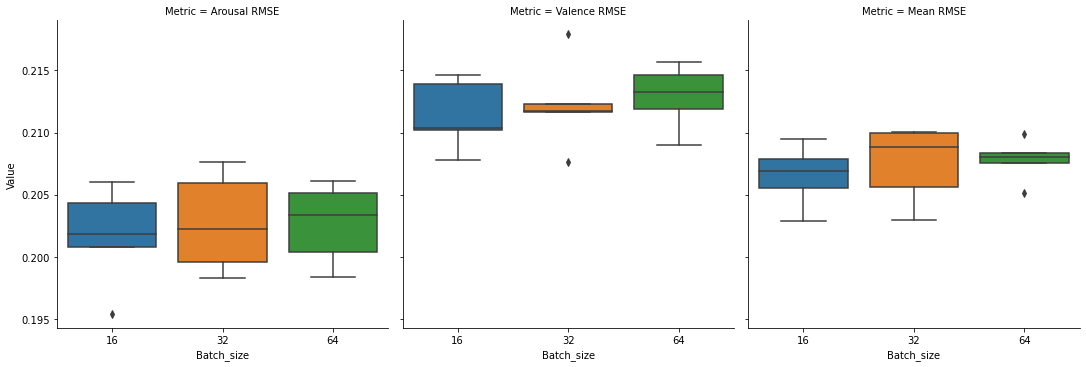

In [ ]:
batch_size_results = pd.DataFrame(results)
sns.catplot(data = batch_size_results, x = "Batch_size", y = "Value", col = "Metric", kind = "box")

# Can we improve it with augmentations?

Not really

In [ ]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 16

train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = batch_size)


In [ ]:
augmented_X = (load_X("little_noise", train_ids, seq_len = SEQ_LEN) - mean) / std

augmented_a = torch.tensor(arousal.loc[train_ids].to_numpy().flatten(), dtype = torch.float)
augmented_v = torch.tensor(valence.loc[train_ids].to_numpy().flatten(), dtype = torch.float)

augmented_dataset = TensorDataset(
    torch.cat((train_X, augmented_X), dim = 0),
    torch.cat((train_a, augmented_a), dim = 0), 
    torch.cat((train_v, augmented_v), dim = 0),
)

augmented_loader = DataLoader(augmented_dataset, batch_size = BATCH_SIZE, shuffle = True)


In [ ]:
noisy_X = (load_X("medium_noise", train_ids, seq_len = SEQ_LEN) - mean) / std

noisy_a = torch.tensor(arousal.loc[train_ids].to_numpy().flatten(), dtype = torch.float)
noisy_v = torch.tensor(valence.loc[train_ids].to_numpy().flatten(), dtype = torch.float)

noisy_dataset = TensorDataset(
    torch.cat((train_X, noisy_X), dim = 0),
    torch.cat((train_a, noisy_a), dim = 0), 
    torch.cat((train_v, noisy_v), dim = 0),
)

noisy_loader = DataLoader(noisy_dataset, batch_size = BATCH_SIZE, shuffle = True)


In [ ]:
results = []

for _ in tqdm(range(5)):
  model = Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT)
  a_rmse, v_rmse = train_and_get_rmse(model, train_loader, epochs = 5)
  results.append({"Metric": "Arousal RMSE", "Value": a_rmse, "Dataset": "Default"})
  results.append({"Metric": "Valence RMSE", "Value": v_rmse, "Dataset": "Default"})
  results.append({"Metric": "Mean RMSE", "Value": (a_rmse + v_rmse) / 2, "Dataset": "Default"})

100%|██████████| 5/5 [01:24<00:00, 16.88s/it]


In [ ]:
for _ in tqdm(range(5)):
  model = Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT)
  a_rmse, v_rmse = train_and_get_rmse(model, augmented_loader, epochs = 5)
  results.append({"Metric": "Arousal RMSE", "Value": a_rmse, "Dataset": "Little noise"})
  results.append({"Metric": "Valence RMSE", "Value": v_rmse, "Dataset": "Little noise"})
  results.append({"Metric": "Mean RMSE", "Value": (a_rmse + v_rmse) / 2, "Dataset": "Little noise"})

100%|██████████| 5/5 [09:01<00:00, 108.30s/it]


In [ ]:
for _ in tqdm(range(5)):
  model = Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT)
  a_rmse, v_rmse = train_and_get_rmse(model, noisy_loader, epochs = 5)
  results.append({"Metric": "Arousal RMSE", "Value": a_rmse, "Dataset": "Medium noise"})
  results.append({"Metric": "Valence RMSE", "Value": v_rmse, "Dataset": "Medium noise"})
  results.append({"Metric": "Mean RMSE", "Value": (a_rmse + v_rmse) / 2, "Dataset": "Medium noise"})

100%|██████████| 5/5 [09:00<00:00, 108.01s/it]


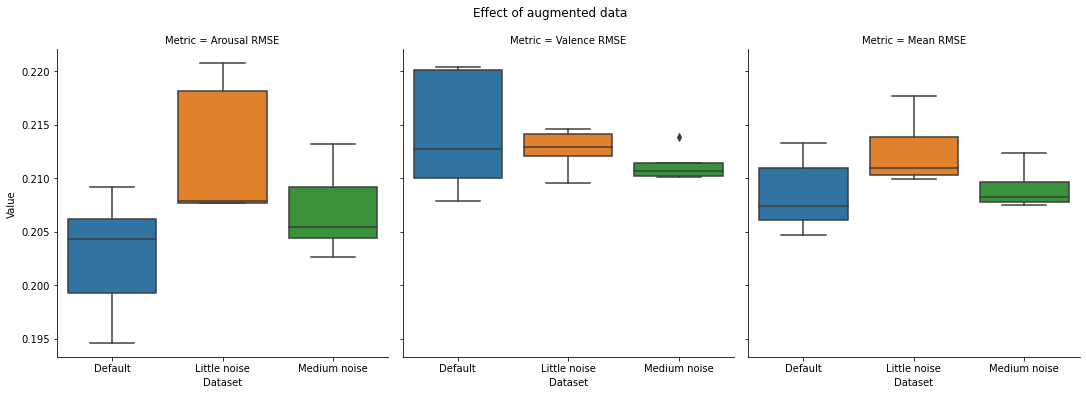

In [ ]:
validation_data = pd.DataFrame(results)
sns.catplot(x = "Dataset", y = "Value", col = "Metric", kind = "box", data = validation_data)
plt.suptitle("Effect of augmented data", y = 1.05)
plt.show()

# Overfitting example

In [ ]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 16

train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
model = Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)

model = model.cuda()

loss_values = []

for epoch in range(20):  
  model.train()
  train_a_loss = 0.0
  train_v_loss = 0.0
  for i, data in enumerate(train_loader, 0):
    x, a, v = data

    x = x.cuda()
    a = a.cuda()
    v = v.cuda()

    optimizer.zero_grad()

    # forward + backward + optimize
    a_out, v_out = model(x)
    a_loss = criterion(a_out, a)
    v_loss = criterion(v_out, v) 
    
    total_loss = a_loss + v_loss
    total_loss.backward()


    optimizer.step()

    # print statistics
    train_a_loss += a_loss.item()
    train_v_loss += v_loss.item()
  

  valid_a_loss = 0.0
  valid_v_loss = 0.0
  with torch.no_grad():
    model.eval()
    for data in valid_loader:
      x, a, v = data

      x = x.cuda()
      a = a.cuda()
      v = v.cuda()

      optimizer.zero_grad()

      a_out, v_out = model(x)
      a_loss = criterion(a_out, a)
      v_loss = criterion(v_out, v) 

      valid_a_loss += a_loss.item()
      valid_v_loss += v_loss.item()

  loss_values.append({"Dataset": "Train", "Feature": "Arousal", "Epoch": epoch + 1, "Value": train_a_loss * BATCH_SIZE / len(train_dataset)})
  loss_values.append({"Dataset": "Validation", "Feature": "Arousal", "Epoch": epoch + 1, "Value": valid_a_loss * BATCH_SIZE / len(valid_dataset)})

  loss_values.append({"Dataset": "Train", "Feature": "Valence", "Epoch": epoch + 1, "Value": train_v_loss * BATCH_SIZE / len(train_dataset)})
  loss_values.append({"Dataset": "Validation", "Feature": "Valence", "Epoch": epoch + 1, "Value": valid_v_loss * BATCH_SIZE / len(valid_dataset)})


  print(f"END OF EPOCH {epoch + 1} | Training arousal loss: {train_a_loss * BATCH_SIZE / len(train_dataset):.6f} | Validation arousal loss: {valid_a_loss * BATCH_SIZE / len(valid_dataset):.6f}")
  print(f"               | Training valence loss: {train_v_loss * BATCH_SIZE / len(train_dataset):.6f} | Validation valence loss: {valid_v_loss * BATCH_SIZE / len(valid_dataset):.6f}")


END OF EPOCH 1 | Training arousal loss: 0.045813 | Validation arousal loss: 0.047201
               | Training valence loss: 0.049905 | Validation valence loss: 0.047563
END OF EPOCH 2 | Training arousal loss: 0.033569 | Validation arousal loss: 0.038788
               | Training valence loss: 0.039681 | Validation valence loss: 0.043276
END OF EPOCH 3 | Training arousal loss: 0.031026 | Validation arousal loss: 0.041408
               | Training valence loss: 0.036512 | Validation valence loss: 0.044941
END OF EPOCH 4 | Training arousal loss: 0.029665 | Validation arousal loss: 0.038856
               | Training valence loss: 0.034478 | Validation valence loss: 0.046470
END OF EPOCH 5 | Training arousal loss: 0.028701 | Validation arousal loss: 0.039618
               | Training valence loss: 0.033269 | Validation valence loss: 0.047507
END OF EPOCH 6 | Training arousal loss: 0.028201 | Validation arousal loss: 0.039087
               | Training valence loss: 0.032034 | Validation val

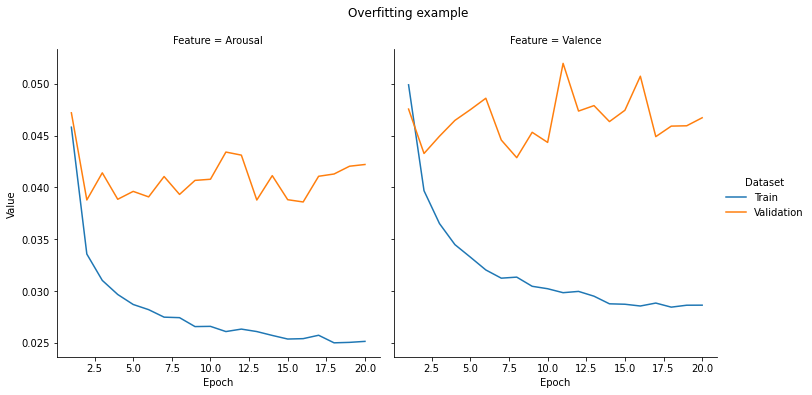

In [ ]:
loss_df = pd.DataFrame(loss_values)
loss_df = loss_df.rename({"Value": "Loss value"})

sns.relplot(data = loss_df, x = "Epoch", y = "Value", hue = "Dataset", col = "Feature", kind = "line")
plt.suptitle("Overfitting example", y = 1.05)
plt.show()

# Final evaluation of single models

In [ ]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 16

train_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
final_rmse_values = []

for _ in tqdm(range(10)):
  model = Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT)
  model = train_model(model, train_loader, epochs = 5)
  model.eval()
  
  train_a_rmse, train_v_rmse = get_rmse(model, train_X, train_a, train_v)
  valid_a_rmse, valid_v_rmse = get_rmse(model, valid_X, valid_a, valid_v)
  test_a_rmse, test_v_rmse = get_rmse(model, test_X, test_a, test_v)

  final_rmse_values.append({"Arousal_RMSE": train_a_rmse, "Valence_RMSE": train_v_rmse, "Dataset": "Train"})
  # final_rmse_values.append({"Arousal_RMSE": valid_a_rmse, "Valence_RMSE": valid_v_rmse, "Dataset": "Valid"})
  final_rmse_values.append({"Arousal_RMSE": test_a_rmse, "Valence_RMSE": test_v_rmse, "Dataset": "Test"})


100%|██████████| 10/10 [11:39<00:00, 69.90s/it]


In [ ]:
final_rmse_df = pd.DataFrame(final_rmse_values)

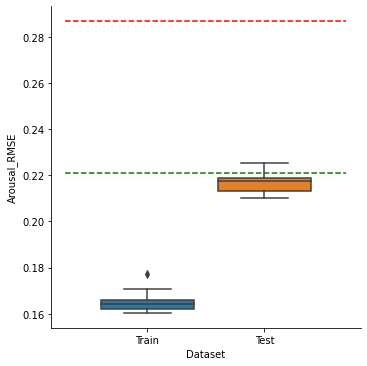

In [ ]:
sns.catplot(data = final_rmse_df, x = "Dataset", y = "Arousal_RMSE", kind = "box")
plt.hlines(0.2211, xmin = -0.7, xmax = 1.7, colors = 'g', linestyles = "--")
plt.hlines((train_a.mean() - test_a).pow(2).mean().sqrt(), xmin = -0.7, xmax = 1.7, colors = 'r', linestyles = "--")

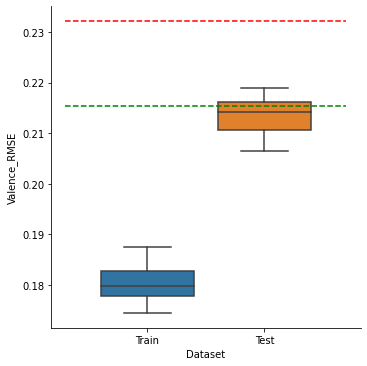

In [ ]:
sns.catplot(data = final_rmse_df, x = "Dataset", y = "Valence_RMSE", kind = "box")
plt.hlines(0.2153, xmin = -0.7, xmax = 1.7, colors = 'g', linestyles = "--")
plt.hlines((train_v.mean() - test_v).pow(2).mean().sqrt(), xmin = -0.7, xmax = 1.7, colors = 'r', linestyles = "--")

# Ensembles

Ensembles improve the results

The best average validation RMSE was obtained with 10 learners over 5 epochs, but 5 learners over 3 epochs were chosen – the result is not that different with much less effort 

In [ ]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 16

train_X, valid_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (train_ids, valid_ids, test_ids)]
train_a, valid_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]
train_v, valid_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (train_ids, valid_ids, test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

valid_dataset = TensorDataset(valid_X, valid_a, valid_v)
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
class Ensemble():
  def __init__(self, models):
    self.models = models
  
  def __call__(self, x):
    a_preds, v_preds = [], []
    for model in models:
      model.eval()
      a, v = model(x)
      a_preds.append(a)
      v_preds.append(v)
    a_prediction = torch.stack(a_preds).mean(dim = 0)
    v_prediction = torch.stack(v_preds).mean(dim = 0)
    return a_prediction, v_prediction

In [ ]:
EPOCHS = [1, 3, 5]
LEARNERS = [3, 5, 10]

for epochs, learners in itertools.product(EPOCHS, LEARNERS):
  models = [train_model(Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = epochs) for _ in range(learners)]
  e = Ensemble(models)
  rmse = get_rmse(e, valid_X, valid_a, valid_v)
  print(f"{learners} learners after {epochs} epochs | Arousal RMSE {rmse[0]:.6f} | Valence RMSE {rmse[1]:.6f}")

3 learners after 1 epochs | Arousal RMSE 0.203365 | Valence RMSE 0.215842
5 learners after 1 epochs | Arousal RMSE 0.199533 | Valence RMSE 0.215722
10 learners after 1 epochs | Arousal RMSE 0.198364 | Valence RMSE 0.212750
3 learners after 3 epochs | Arousal RMSE 0.200355 | Valence RMSE 0.210850
5 learners after 3 epochs | Arousal RMSE 0.192324 | Valence RMSE 0.210098
10 learners after 3 epochs | Arousal RMSE 0.195377 | Valence RMSE 0.207781
3 learners after 5 epochs | Arousal RMSE 0.197905 | Valence RMSE 0.219346
5 learners after 5 epochs | Arousal RMSE 0.195466 | Valence RMSE 0.209506
10 learners after 5 epochs | Arousal RMSE 0.193085 | Valence RMSE 0.206325


# Ensemble evaluation

In [ ]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 16

train_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
ensemble_rmse_values = []

for _ in tqdm(range(10)):
  models = [train_model(Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = 3) for _ in range(5)]
  e = Ensemble(models)
  
  train_a_rmse, train_v_rmse = get_rmse(e, train_X, train_a, train_v)
  valid_a_rmse, valid_v_rmse = get_rmse(e, valid_X, valid_a, valid_v)
  test_a_rmse, test_v_rmse = get_rmse(e, test_X, test_a, test_v)

  ensemble_rmse_values.append({"Arousal_RMSE": train_a_rmse, "Valence_RMSE": train_v_rmse, "Dataset": "Train"})
  ensemble_rmse_values.append({"Arousal_RMSE": test_a_rmse, "Valence_RMSE": test_v_rmse, "Dataset": "Test"})


100%|██████████| 10/10 [35:06<00:00, 210.66s/it]


In [ ]:
ensemble_rmse_df = pd.DataFrame(ensemble_rmse_values)

In [ ]:
final_rmse_df["Model"] = "Single"
ensemble_rmse_df["Model"] = "Ensemble"

rmse_df = pd.concat([final_rmse_df, ensemble_rmse_df])

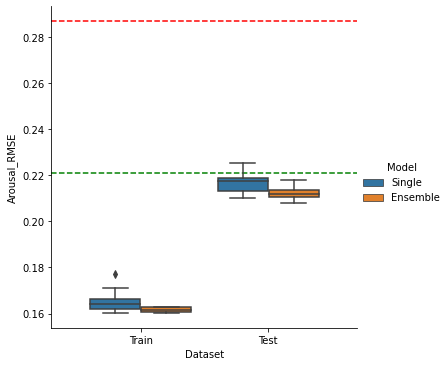

In [ ]:
sns.catplot(data = rmse_df, x = "Dataset", y = "Arousal_RMSE", hue = "Model", kind = "box")
plt.hlines(0.2211, xmin = -0.7, xmax = 1.7, colors = 'g', linestyles = "--")
plt.hlines((train_a.mean() - test_a).pow(2).mean().sqrt(), xmin = -0.7, xmax = 1.7, colors = 'r', linestyles = "--")

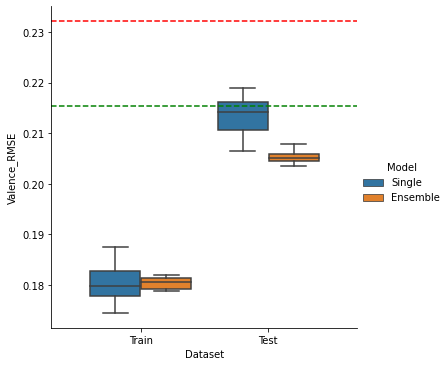

In [ ]:
sns.catplot(data = rmse_df, x = "Dataset", y = "Valence_RMSE", hue = "Model", kind = "box")
plt.hlines(0.2153, xmin = -0.7, xmax = 1.7, colors = 'g', linestyles = "--")
plt.hlines((train_v.mean() - test_v).pow(2).mean().sqrt(), xmin = -0.7, xmax = 1.7, colors = 'r', linestyles = "--")

In [ ]:
rmse_df.groupby(["Dataset", "Model"]).agg(["mean", "std"])

Arousal_RMSE           Valence_RMSE          
                         mean       std         mean       std
Dataset Model                                                 
Test    Ensemble     0.212226  0.002881     0.205306  0.001443
        Single       0.216991  0.005141     0.213533  0.004110
Train   Ensemble     0.161590  0.001102     0.180414  0.001266
        Single       0.165505  0.005076     0.180296  0.004414

# Real vs. predicted values

In [8]:
class Forked_GRU(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0, bidirectional = False):
    super(Forked_GRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional

    self.GRU = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)
    self.dropout = nn.Dropout(p = p_dropout)

    self.FC1_a = nn.Linear(hidden_size, 5)
    self.FC2_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size, 5)
    self.FC2_v = nn.Linear(5, 1)

  def forward(self, x):
    x, _ = self.GRU(x)
    x = x[:,-1,:] # Taking the final output only

    x = F.relu(x)
    x = self.dropout(x)

    a = F.relu(self.FC1_a(x))
    a = torch.tanh(self.FC2_a(a)).flatten()

    v = F.relu(self.FC1_v(x))
    v = torch.tanh(self.FC2_v(v)).flatten()
    return a, v

In [9]:
class Ensemble():
  def __init__(self, models):
    self.models = models
  
  def __call__(self, x):
    a_preds, v_preds = [], []
    for model in models:
      model.eval()
      a, v = model(x)
      a_preds.append(a)
      v_preds.append(v)
    a_prediction = torch.stack(a_preds).mean(dim = 0)
    v_prediction = torch.stack(v_preds).mean(dim = 0)
    return a_prediction, v_prediction

In [10]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 16

train_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [11]:
models = [train_model(Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = 3) for _ in range(5)]
e = Ensemble(models)

In [48]:
pred_train_a, pred_train_v = e(train_X.cuda())
pred_test_a, pred_test_v = e(test_X.cuda())

In [49]:
pred_df = pd.concat([
  pd.DataFrame({"Real value": train_a, "Predicted value": pred_train_a.cpu().detach(), "Parameter": "Arousal", "Dataset": "Train"}),
  pd.DataFrame({"Real value": train_v, "Predicted value": pred_train_v.cpu().detach(), "Parameter": "Valence", "Dataset": "Train"}),
  pd.DataFrame({"Real value": test_a, "Predicted value": pred_test_a.cpu().detach(), "Parameter": "Arousal", "Dataset": "Test"}),
  pd.DataFrame({"Real value": test_v, "Predicted value": pred_test_v.cpu().detach(), "Parameter": "Valence", "Dataset": "Test"}),
])

pred_df

,Real value,Predicted value,Parameter,Dataset
0,-0.109388,-0.093402,Arousal,Train
1,-0.114943,-0.032406,Arousal,Train
2,-0.116414,-0.084972,Arousal,Train
3,-0.118614,-0.068297,Arousal,Train
4,-0.126458,-0.056379,Arousal,Train
...,...,...,...,...
7495,0.288580,0.214637,Valence,Test
7496,0.289080,0.224533,Valence,Test
7497,0.287102,0.169897,Valence,Test
7498,0.285324,0.182477,Valence,Test


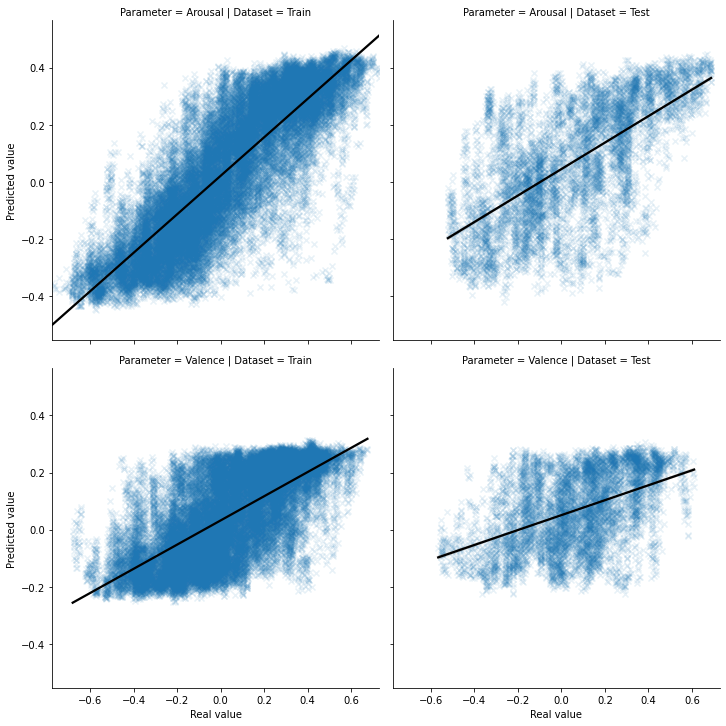

In [50]:
sns.lmplot(data = pred_df, x = "Real value", y = "Predicted value", row = "Parameter", col = "Dataset",
           markers = "x", scatter_kws = {"alpha": 0.1}, line_kws = {"color": "black"})

# Arousal and valence correlation

Forked model gives high correlation between arousal and valence, which is not good

In [38]:
class Forked_GRU_Up(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0, bidirectional = False):
    super(Forked_GRU_Up, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional

    self.GRU = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)
    self.dropout = nn.Dropout(p = p_dropout)

    self.FC1_a = nn.Linear(hidden_size, 20)
    self.FC2_a = nn.Linear(20, 5)
    self.FC3_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size, 20)
    self.FC2_v = nn.Linear(20, 5)
    self.FC3_v = nn.Linear(5, 1)

  def forward(self, x):
    x, _ = self.GRU(x)
    x = x[:,-1,:] # Taking the final output only

    x = F.relu(x)
    x = self.dropout(x)

    a = F.relu(self.FC1_a(x))
    a = F.relu(self.FC2_a(a))
    a = torch.tanh(self.FC3_a(a)).flatten()

    v = F.relu(self.FC1_v(x))
    v = F.relu(self.FC2_v(v))
    v = torch.tanh(self.FC3_v(v)).flatten()
    return a, v

In [66]:
class Paralel_GRU(nn.Module):
  def __init__(self, hidden_size, num_layers = 1, p_dropout = 0, bidirectional = False):
    super(Paralel_GRU, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional

    self.GRU_a = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)
    self.GRU_v = nn.GRU(68, hidden_size, num_layers = num_layers, batch_first = True, dropout = p_dropout if num_layers > 1 else 0, bidirectional = bidirectional)

    self.dropout_a = nn.Dropout(p = p_dropout)
    self.dropout_v = nn.Dropout(p = p_dropout)

    self.FC1_a = nn.Linear(hidden_size, 20)
    self.FC2_a = nn.Linear(20, 5)
    self.FC3_a = nn.Linear(5, 1)

    self.FC1_v = nn.Linear(hidden_size, 20)
    self.FC2_v = nn.Linear(20, 5)
    self.FC3_v = nn.Linear(5, 1)

  def forward(self, x):
    a, _ = self.GRU_a(x)
    a = a[:,-1,:] # Taking the final output only

    a = F.relu(a)
    a = self.dropout_a(a)
    a = F.relu(self.FC1_a(a))
    a = F.relu(self.FC2_a(a))
    a = torch.tanh(self.FC3_a(a)).flatten()

    v, _ = self.GRU_v(x)
    v = v[:,-1,:] # Taking the final output only

    v = F.relu(self.FC1_v(v))
    v = F.relu(self.FC2_v(v))
    v = torch.tanh(self.FC3_v(v)).flatten()
    return a, v

In [67]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 32

train_X, test_X = [(load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_a, test_a = [torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]
train_v, test_v = [torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float) for ids in (list(train_ids) + list(valid_ids), test_ids)]

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

test_dataset = TensorDataset(test_X, test_a, test_v)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [70]:
real_df = pd.concat([
  pd.DataFrame({"Arousal": train_a, "Valence": train_v, "Method": "Truth", "Dataset": "Train"}),
  pd.DataFrame({"Arousal": test_a, "Valence": test_v, "Method": "Truth", "Dataset": "Test"}),
])

In [73]:
models = [train_model(Paralel_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = 3) for _ in tqdm(range(5))]
e = Ensemble(models)

pred_train_a, pred_train_v = e(train_X.cuda())
pred_test_a, pred_test_v = e(test_X.cuda())

paralel_df = pd.concat([
  pd.DataFrame({"Arousal": pred_train_a.cpu().detach(), "Valence": pred_train_v.cpu().detach(), "Method": "Paralel", "Dataset": "Train"}),
  pd.DataFrame({"Arousal": pred_test_a.cpu().detach(), "Valence": pred_test_v.cpu().detach(), "Method": "Paralel", "Dataset": "Test"}),
])

100%|██████████| 5/5 [02:46<00:00, 33.40s/it]


In [75]:
models = [train_model(Forked_GRU_Up(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = 3) for _ in tqdm(range(5))]
e = Ensemble(models)

pred_train_a, pred_train_v = e(train_X.cuda())
pred_test_a, pred_test_v = e(test_X.cuda())

forked_df = pd.concat([
  pd.DataFrame({"Arousal": pred_train_a.cpu().detach(), "Valence": pred_train_v.cpu().detach(), "Method": "Forked", "Dataset": "Train"}),
  pd.DataFrame({"Arousal": pred_test_a.cpu().detach(), "Valence": pred_test_v.cpu().detach(), "Method": "Forked", "Dataset": "Test"}),
])

100%|██████████| 5/5 [01:59<00:00, 23.83s/it]


In [76]:
pred_2d_df = pd.concat([real_df, paralel_df, forked_df])
pred_2d_df

,Arousal,Valence,Method,Dataset
0,-0.109388,-0.073341,Truth,Train
1,-0.114943,-0.074662,Truth,Train
2,-0.116414,-0.074078,Truth,Train
3,-0.118614,-0.078155,Truth,Train
4,-0.126458,-0.081589,Truth,Train
...,...,...,...,...
7495,0.340971,0.203451,Forked,Test
7496,0.318746,0.214643,Forked,Test
7497,0.343152,0.137094,Forked,Test
7498,0.331827,0.142575,Forked,Test


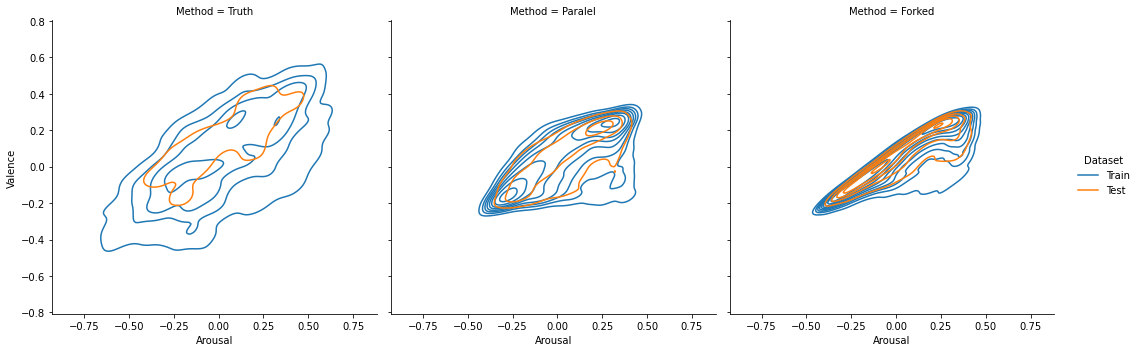

In [85]:
sns.displot(data = pred_2d_df, x = "Arousal", y = "Valence", hue = "Dataset", col = "Method", kind = "kde")
plt.show()

In [83]:
from scipy.stats import pearsonr 

for method in pred_2d_df.Method.unique():
  selected_df = pred_2d_df[pred_2d_df.Method == method]
  print(method, pearsonr(selected_df.Arousal, selected_df.Valence)[0])


Truth 0.5649186768954358
Paralel 0.726897148994496
Forked 0.8863069227800987


# Model for the app

In [51]:
SEQ_LEN = 60
HIDDEN_SIZE = 30
DROPOUT = 0.25
BATCH_SIZE = 16

ids = list(train_ids) + list(valid_ids) + list(test_ids)

train_X = (load_X("paa_features_librosa", ids, seq_len = SEQ_LEN) - mean) / std
train_a = torch.tensor(arousal.loc[ids].to_numpy().flatten(), dtype = torch.float)
train_v = torch.tensor(valence.loc[ids].to_numpy().flatten(), dtype = torch.float)

train_dataset = TensorDataset(train_X, train_a, train_v)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [52]:
models = [train_model(Forked_GRU(hidden_size = HIDDEN_SIZE, num_layers = 1, p_dropout = DROPOUT), train_loader, epochs = 3) for _ in range(5)]

In [54]:
for i, model in enumerate(models):
  torch.save(model.state_dict(), f"/content/drive/MyDrive/UJ/ML/Project/trained_models/model{i}")